# TPC-C Multi-Tenant with Distributed PVC and Tuned MySQL 8.4

* data is generated and loaded into databases in a distributed filesystem
* experiments do not use preloaded data

* MySQL uses improved args:
```
  - "--local-infile=1"
  # --- I/O Threading ---
  - "--innodb-read-io-threads=64"         # Max threads to handle read I/O (use all CPU cores)
  - "--innodb-write-io-threads=64"        # Max threads for write I/O (parallelism on CephFS)
  # --- Async I/O (for CephFS) ---
  - "--innodb-use-native-aio=0"           # Disable native AIO (improves CephFS compatibility)
  # --- Buffer Pool (Main memory cache) ---
  - "--innodb-buffer-pool-size=256G"      # Increased to 256G (out of 500G total RAM)
  - "--innodb-buffer-pool-instances=64"   # One per core for high concurrency
  - "--innodb-buffer-pool-chunk-size=2G"  # Aligns pool size with chunks
  # --- I/O Capacity (for background flushing) ---
  - "--innodb-io-capacity=200"            # Lowered for CephFS latency
  - "--innodb-io-capacity-max=1000"       # Burst capacity still reasonably high
  # --- Redo Log ---
  - "--innodb-log-buffer-size=1G"         # Buffer before flushing to disk
  - "--innodb-redo-log-capacity=4G"       # Redo log capacity for large write bursts
  # --- Transaction Commit Behavior ---
  - "--innodb-flush-log-at-trx-commit=2"  # Flush every second (safe compromise)
  - "--sync-binlog=0"                     # No fsync per transaction (OLAP-friendly)
  # --- Temporary Tables ---
  - "--tmp-table-size=1G"                 # Prevent temp table disk usage
  - "--max-heap-table-size=1G"            # For user-created MEMORY tables
  # --- Change Buffer ---
  - "--innodb-change-buffer-max-size=50"  # % of buffer pool for insert/update/delete buffering
  # --- DDL and Read Parallelism ---
  - "--innodb-parallel-read-threads=64"   # For multi-threaded table scans (OLAP)
  - "--innodb-ddl-threads=32"             # Parallel DDL ops (index creation, etc.)
  - "--innodb-ddl-buffer-size=256M"       # DDL metadata operations memory
  # --- Doublewrite Buffer ---
  - "--innodb-doublewrite=0"              # Disable for CephFS redundancy and speed
  # --- Authentication ---
  - "--mysql-native-password=ON"          # Backward-compatible password auth
```

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from bexhoma import collectors

%matplotlib inline

# Functions for Nice Plots

In [2]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    show_height = False
    if show_height:
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X: center of bar
                    height,                             # Y: top of bar
                    f'{height:.1f}',                    # Text (1 decimal place)
                    ha='center', va='bottom', fontsize=8
                )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

def plot_boxplots(df, y, title):
    plt.figure(figsize=(10, 6))
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    
    # Plot boxplots grouped by num_tenants and colored by type
    ax = sns.boxplot(
        data=df,
        x='num_tenants',
        y=y,#'Goodput (requests/second)',
        hue='type',
        palette='Set2'  # consistent colors per type
    )
    # Add vertical separator lines between groups
    # Get the number of unique num_tenants and type
    num_groups = df['num_tenants'].nunique()
    num_types = df['type'].nunique()
    
    # Extract hue order
    hue_order = ax.get_legend_handles_labels()[1]
    num_hue = len(hue_order)
    
    # Get hue order from seaborn (types)
    _, type_order = ax.get_legend_handles_labels()
    num_types = len(type_order)
    
    #print(len(ax.patches))
    # Set hatches correctly: patches are grouped by x then by hue
    for i, patch in enumerate(ax.patches):
        #print(i)
        type_index = i // (num_groups)
        if type_index >= num_types:
            break
        type_name = type_order[type_index]
        patch.set_hatch(hatch_map.get(type_name, ''))
        #print(hatch_map.get(type_name, ''))
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    
    # Each num_tenants group has num_types boxes
    for i in range(1, num_groups):
        xpos = i - 0.5 #0.5
        ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)
    
    
    # Update legend with matching hatches
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
    
    #title = "Goodput [req/s] Distribution per Tenant"
    plt.title(title, fontsize=24)
    plt.xlabel("Number of Tenants")
    plt.ylabel("")#"Goodput (requests/second)")
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    plt.legend(title="Type")
    ax.legend(fontsize=18)
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Collect Results

In [3]:
path = r"C:\data\benchmarks"
#path = r"/home/perdelt/benchmarks"
filename_prefix = "mysql_"

In [4]:
codes = [
#"1753424125",
    #"1753420948",
    #"1753420083",
    #"1753417127",
    "1753416259",
    #"1753413557",
    "1753412871",
    #"1753410365",
    "1753409786","1753400862",
    #"1753398806",
    "1753391528","1753383856","1753376900","1753370584","1753364157","1753357447","1753350659","1753342868","1753340173","1753337410","1753334504","1753331918","1753329375","1753326800","1753324378","1753321584","1753319860","1753317513","1753315334"
]
codes_no = [
"1753277819","1753284808","1753292344","1753300385","1753308797","1753317513","1753326800","1753337410","1753279518","1753286610","1753294275","1753302473","1753310896","1753319860","1753329375","1753340173","1753281247","1753288480","1753296266","1753304605","1753313115","1753321584","1753331918","1753282948","1753290475","1753298355","1753306706","1753315334","1753324378","1753334504"
]

#1753413557 is empty
#1753410365 is empty
#1753398806 is empty

codes = [c for c in codes if not c in codes_no]
codes

['1753416259',
 '1753412871',
 '1753409786',
 '1753400862',
 '1753391528',
 '1753383856',
 '1753376900',
 '1753370584',
 '1753364157',
 '1753357447',
 '1753350659',
 '1753342868']

In [5]:
collect = collectors.benchbase(path, codes)

In [6]:
df_performance = collect.get_monitoring_single_all("stream")
df_performance

,CPU [CPUs],CPU Throttled,Max CPU,Max RAM [Gb],Max RAM Cached [Gb],Locks,Access Exclusive,Access Share,Exclusive,Row Exclusive,...,Heap Hits,Sync Time,Write Time,Cache Hit Ratio [%],Number Autoanalyze,Number Autovacuum,Variance of Core Util [%],client,type,num_tenants
MySQL-1-1-65536-0-1,700.59,0.0,2.74,35.24,44.33,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,801.47,1,container,1
MySQL-1-1-65536-0-2,1683.87,0.0,2.17,35.39,45.49,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1984.75,2,container,1
MySQL-1-1-65536-1,656.12,0.0,1.68,35.23,44.31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,764.58,1,database,1
MySQL-1-1-65536-2,1113.02,0.0,1.82,35.35,45.14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,847.76,2,database,1
MySQL-1-1-65536-0-1,1554.60,0.0,7.85,35.31,44.97,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2811.62,1,container,2
MySQL-1-1-65536-0-2,972.02,0.0,2.33,35.41,45.68,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3595.98,2,container,2
MySQL-1-1-65536-1-1,1065.50,0.0,4.47,35.27,44.61,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2755.83,1,container,2
MySQL-1-1-65536-1-2,1943.46,0.0,6.51,35.46,46.03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3600.93,2,container,2
MySQL-1-1-65536-1,1220.12,0.0,5.69,36.62,46.72,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1057.74,1,database,2
MySQL-1-1-65536-2,2991.14,0.0,11.21,36.92,48.93,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4067.63,2,database,2


# Monitoring Aggregated Values

In [7]:
df_performance = collect.get_monitoring_all("stream")

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance#[['Max CPU', 'client', 'type', 'num_tenants']]

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Locks,Access Exclusive,Access Share,Exclusive,...,Heap Reads,Heap Hits,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],type,num_tenants
0,1,700.59,35.24,44.33,2.74,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,801.47,container,1
1,2,1683.87,35.39,45.49,2.17,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1984.75,container,1
0,1,656.12,35.23,44.31,1.68,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,764.58,database,1
1,2,1113.02,35.35,45.14,1.82,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,847.76,database,1
0,1,2620.10,70.58,89.58,12.32,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5567.45,container,2
1,2,2915.48,70.87,91.71,8.84,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7196.91,container,2
0,1,1220.12,36.62,46.72,5.69,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1057.74,database,2
1,2,2991.14,36.92,48.93,11.21,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4067.63,database,2
0,1,3221.89,105.81,133.92,8.39,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11649.02,container,3
1,2,3332.82,106.14,136.32,9.03,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10977.06,container,3


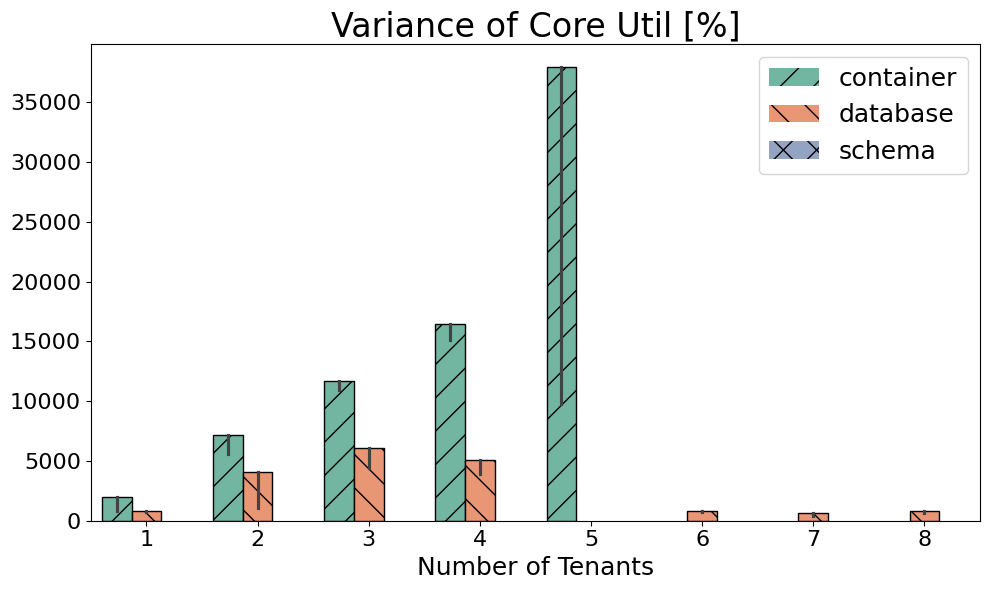

In [8]:
plot_bars(df_performance, y='Variance of Core Util [%]', title='Variance of Core Util [%]', estimator='max')

# Performance Results per Tenant

In [9]:
df_performance = collect.get_performance_all_single()

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance = df_performance.dropna()
df_performance

,connection,configuration,experiment_run,client,pod,pod_count,bench,profile,target,time,...,Goodput (requests/second),Latency Distribution.95th Percentile Latency (microseconds),Latency Distribution.Maximum Latency (microseconds),Latency Distribution.Median Latency (microseconds),Latency Distribution.Minimum Latency (microseconds),Latency Distribution.25th Percentile Latency (microseconds),Latency Distribution.90th Percentile Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),Latency Distribution.75th Percentile Latency (microseconds),Latency Distribution.Average Latency (microseconds)
connection_pod,,,,,,,,,,,,,,,,,,,,,
MySQL-1-1-65536-0-1-1,MySQL-1-1-65536-0-1,MySQL-1-1-65536-0,1,1,vwd69.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,137.648326,73283.0,120617958.0,20649.0,1177.0,13289.0,40522.0,26456247.0,28689.0,666717.0
MySQL-1-1-65536-0-2-1,MySQL-1-1-65536-0-2,MySQL-1-1-65536-0,1,2,7q8jf.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,334.096649,55811.0,81735507.0,20371.0,1069.0,13098.0,38598.0,5554899.0,28133.0,286700.0
MySQL-1-1-65536-1-1,MySQL-1-1-65536-1,MySQL-1-1-65536,1,1,5dphl.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,126.946655,80363.0,89701780.0,19854.0,1066.0,12366.0,46874.0,34515793.0,29386.0,731623.0
MySQL-1-1-65536-2-1,MySQL-1-1-65536-2,MySQL-1-1-65536,1,2,ndfzx.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,273.379994,66398.0,78231761.0,19274.0,1040.0,12067.0,43095.0,7978867.0,28001.0,356458.0
MySQL-1-1-65536-0-1-1,MySQL-1-1-65536-0-1,MySQL-1-1-65536-0,1,1,c7sl7.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,316.441656,71840.0,84174867.0,20500.0,986.0,12999.0,44133.0,5113116.0,29556.0,301921.0
MySQL-1-1-65536-1-1-1,MySQL-1-1-65536-1-1,MySQL-1-1-65536-1,1,1,sbbtn.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,211.314982,125835.0,100245510.0,20682.0,1089.0,12770.0,57497.0,7190948.0,31996.0,441540.0
MySQL-1-1-65536-1-2-1,MySQL-1-1-65536-1-2,MySQL-1-1-65536-1,1,2,4tkts.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,427.593297,83212.0,109382315.0,19594.0,972.0,12279.0,46518.0,4300443.0,28654.0,227935.0
MySQL-1-1-65536-0-2-1,MySQL-1-1-65536-0-2,MySQL-1-1-65536-0,1,2,jvkl9.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,216.709983,105116.0,110282680.0,20142.0,971.0,12739.0,46105.0,4643754.0,28947.0,447818.0
MySQL-1-1-65536-1-1,MySQL-1-1-65536-1,MySQL-1-1-65536,1,1,qnnnx.dbmsbenchmarker,2,tpcc,mysql,65536,600,...,167.396665,73586.0,122675903.0,20472.0,1084.0,12904.0,48139.0,4977564.0,29981.0,567000.0


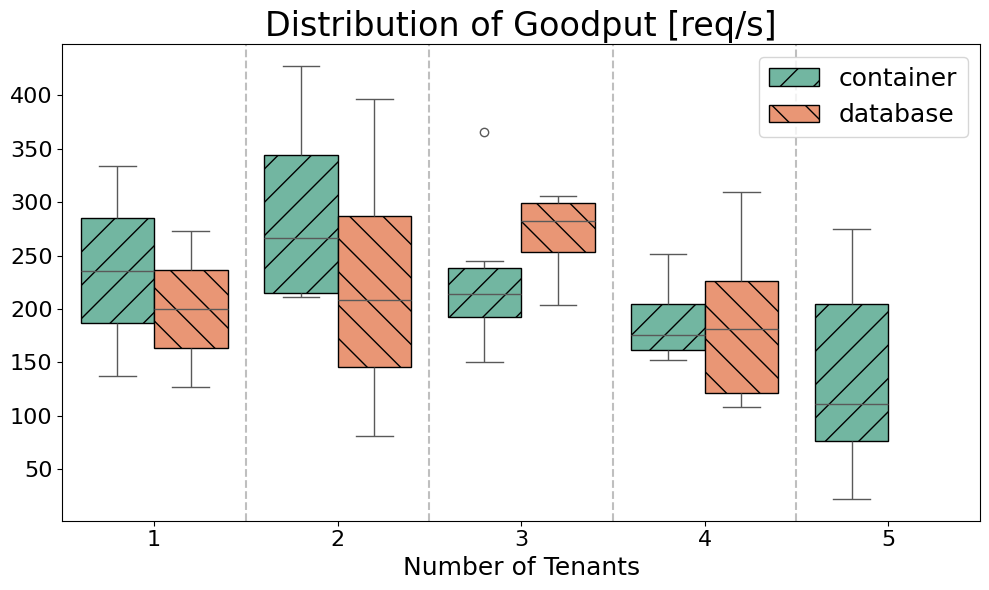

In [10]:
plot_boxplots(df_performance, y='Goodput (requests/second)', title='Distribution of Goodput [req/s]')

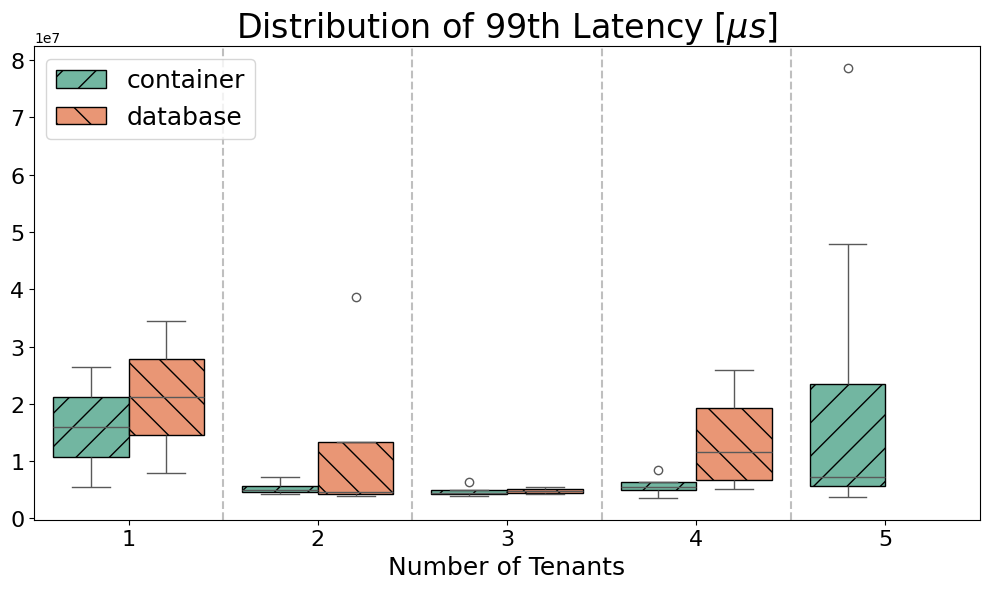

In [11]:
plot_boxplots(df_performance, y='Latency Distribution.99th Percentile Latency (microseconds)', title='Distribution of 99th Latency [$\mu s$]')

# Performance Results per Total

In [12]:
df_performance = collect.get_performance_all()
df_performance = df_performance.dropna()
df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance.dropna(inplace=True)

1753416259 has missing performance
1753412871 has missing performance
1753409786 has missing performance


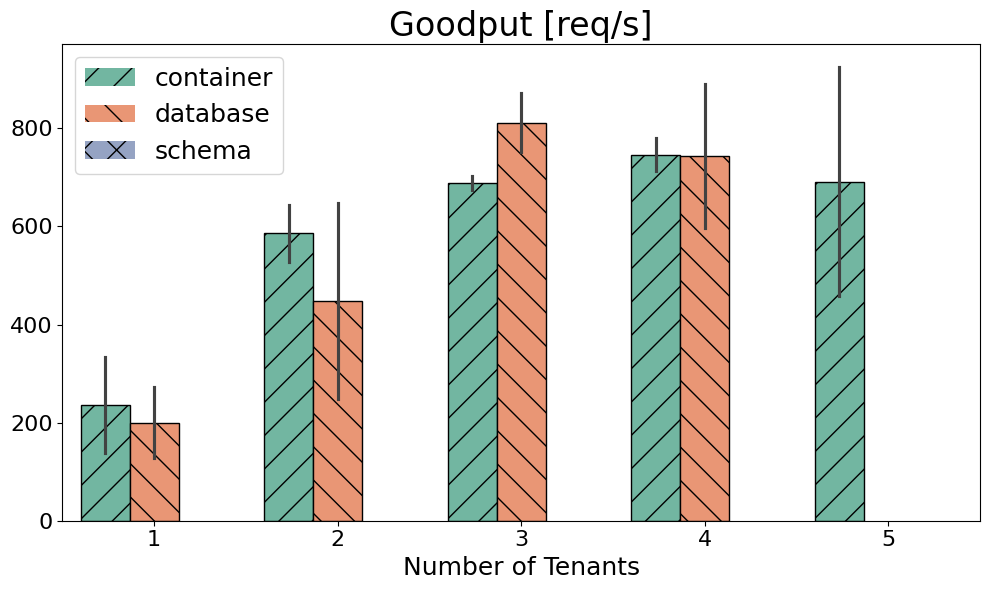

In [13]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='mean')

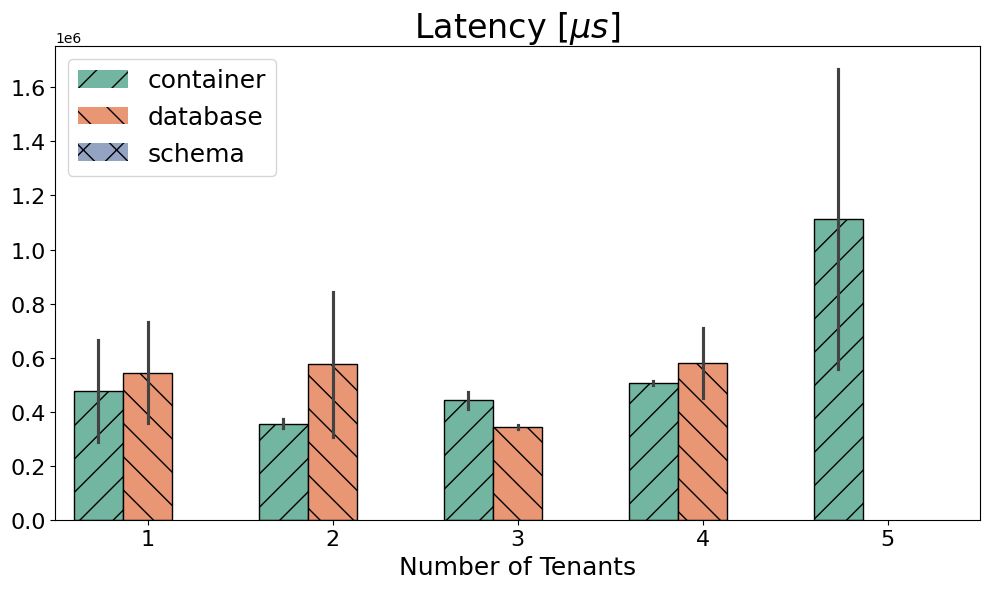

In [14]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='mean')

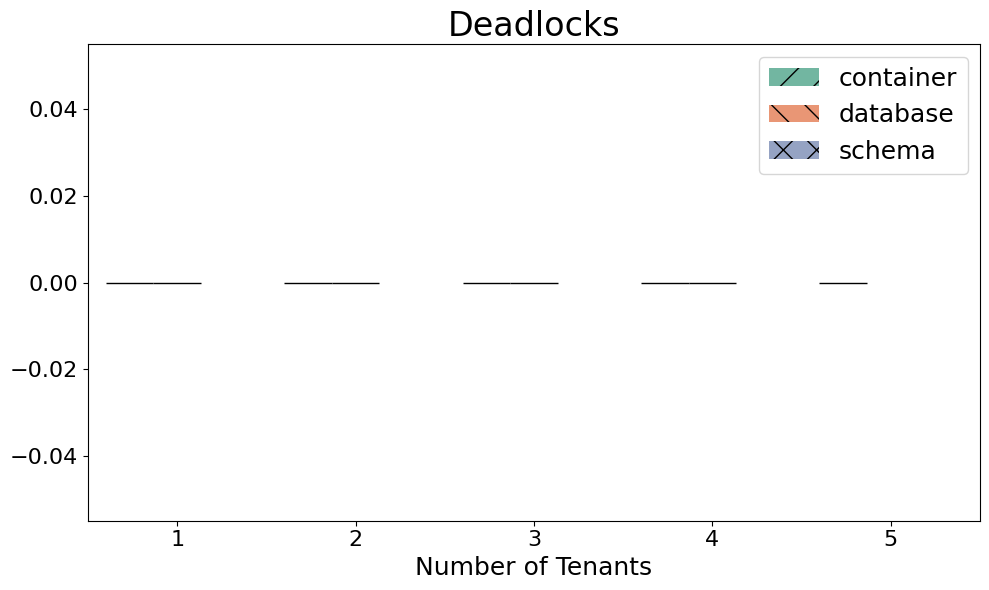

In [15]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [16]:
df_performance = collect.get_loading_time_max_all()

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk,type,num_tenants
MySQL-1-1-65536-0-1,9264.0,4615.0,4635.0,1,1,0,1,10096,container,1
MySQL-1-1-65536-0-2,9264.0,4615.0,4635.0,1,1,0,2,10619,container,1
MySQL-1-1-65536-1,11638.0,5803.0,5820.0,1,1,,1,10092,database,1
MySQL-1-1-65536-2,11638.0,5803.0,5820.0,1,1,,2,10581,database,1
MySQL-1-1-65536-0-1,8703.0,4333.0,4353.0,1,1,0,1,10084,container,2
MySQL-1-1-65536-0-2,8703.0,4333.0,4353.0,1,1,0,2,11249,container,2
MySQL-1-1-65536-1-1,8596.0,4227.0,4352.0,1,1,1,1,10092,container,2
MySQL-1-1-65536-1-2,8596.0,4227.0,4352.0,1,1,1,2,10887,container,2
MySQL-1-1-65536-1,9732.0,4837.0,4860.0,1,2,,1,11903,database,2
MySQL-1-1-65536-2,9732.0,4837.0,4860.0,1,2,,2,12883,database,2


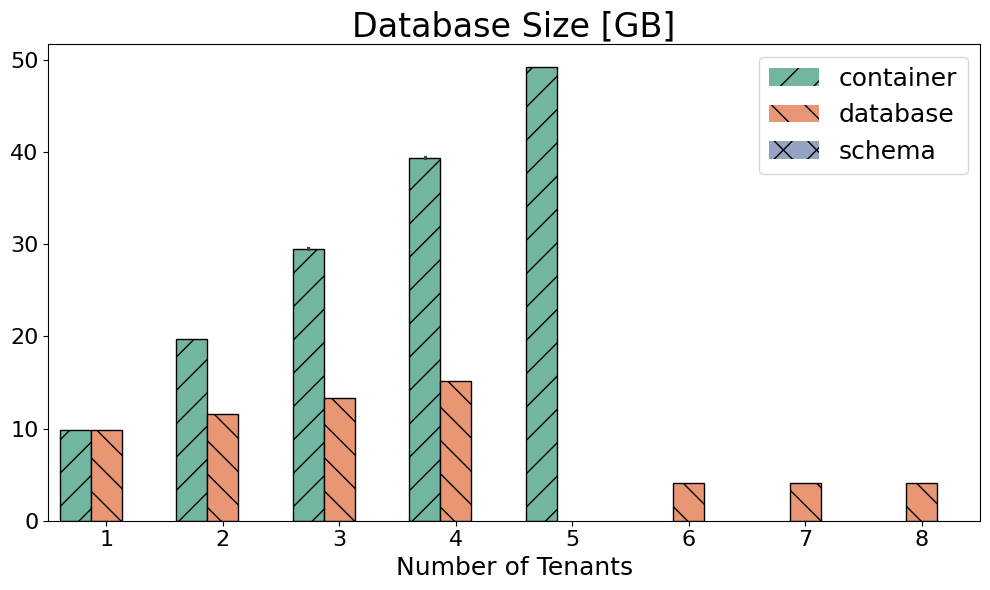

In [17]:
#df_performance_first = df_performance[df_performance['client'] == '1']
# Divide datadisk by the count of rows with the same type and num_tenants
df = df_performance_first.copy()
# Create a mask for rows where type is not "container"
mask = df['type'] != 'container'

# Only apply the group count to the relevant rows
group_counts = df[mask].groupby(['type', 'num_tenants'])['datadisk'].transform('count')

# Initialize the column with NaN (or 0, if preferred)
df['datadisk_normalized'] = df['datadisk'] / 1024

# Apply the normalized value only where the mask is True
df.loc[mask, 'datadisk_normalized'] = df.loc[mask, 'datadisk'] / group_counts / 1024

plot_bars(df, y='datadisk_normalized', title='Database Size [GB]', estimator='sum')

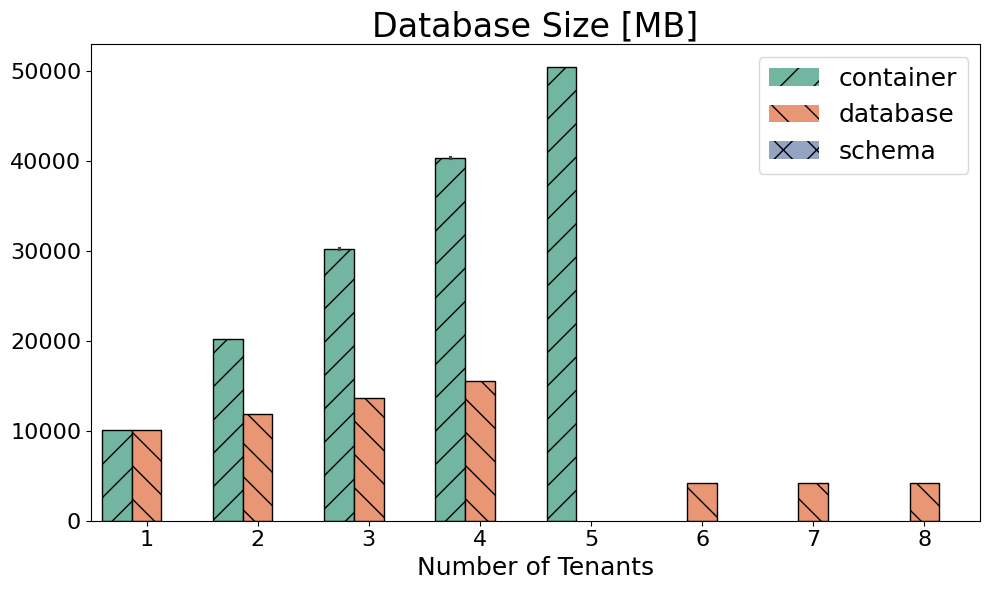

In [18]:
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='sum')

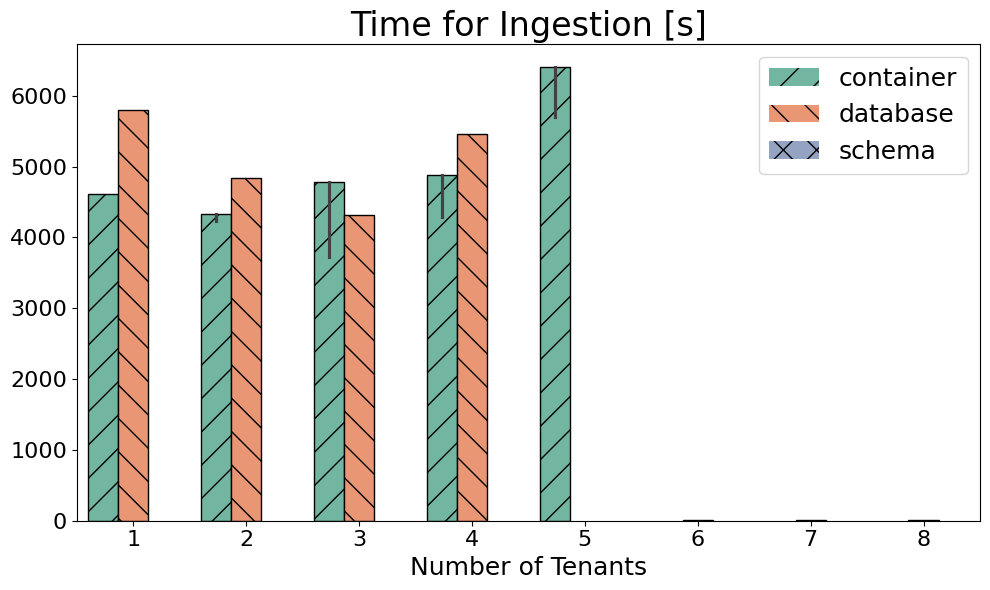

In [19]:
plot_bars(df_performance_first, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

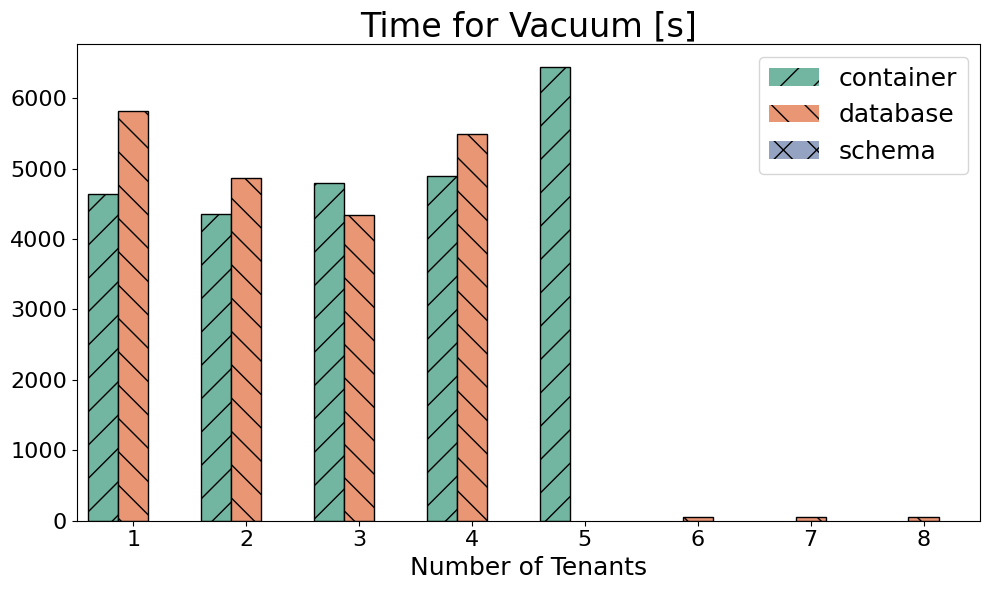

In [20]:
plot_bars(df_performance_first, y='time_check', title='Time for Vacuum [s]', estimator='max')

# Hardware Monitoring for Benchmarking Phase

In [21]:
df_performance = collect.get_monitoring_all(type="stream")

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Locks,Access Exclusive,Access Share,Exclusive,...,Heap Reads,Heap Hits,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],type,num_tenants
0,1,700.59,35.24,44.33,2.74,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,801.47,container,1
1,2,1683.87,35.39,45.49,2.17,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1984.75,container,1
0,1,656.12,35.23,44.31,1.68,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,764.58,database,1
1,2,1113.02,35.35,45.14,1.82,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,847.76,database,1
0,1,2620.10,70.58,89.58,12.32,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5567.45,container,2
1,2,2915.48,70.87,91.71,8.84,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7196.91,container,2
0,1,1220.12,36.62,46.72,5.69,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1057.74,database,2
1,2,2991.14,36.92,48.93,11.21,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4067.63,database,2
0,1,3221.89,105.81,133.92,8.39,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11649.02,container,3
1,2,3332.82,106.14,136.32,9.03,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10977.06,container,3


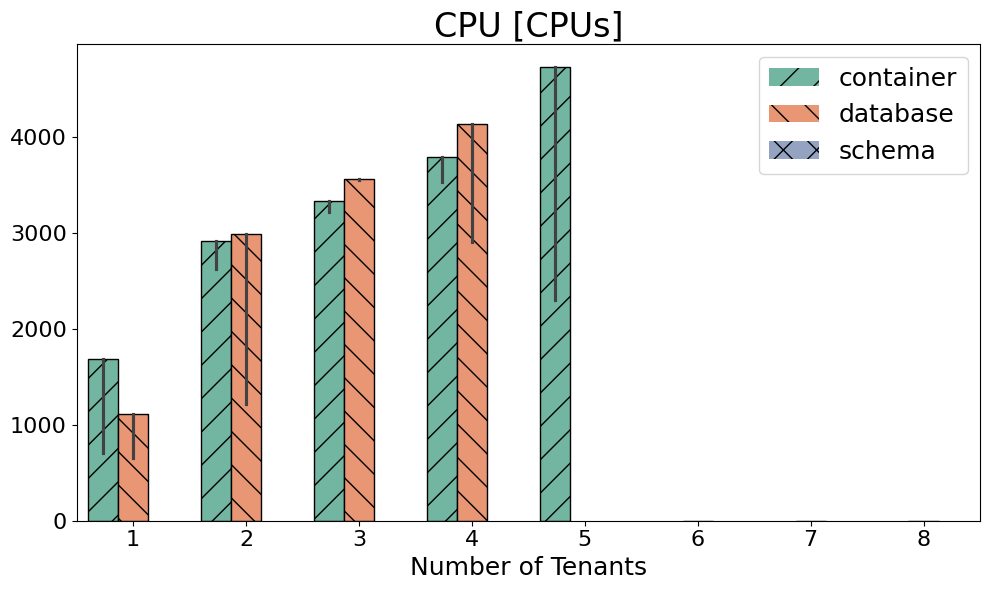

In [22]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

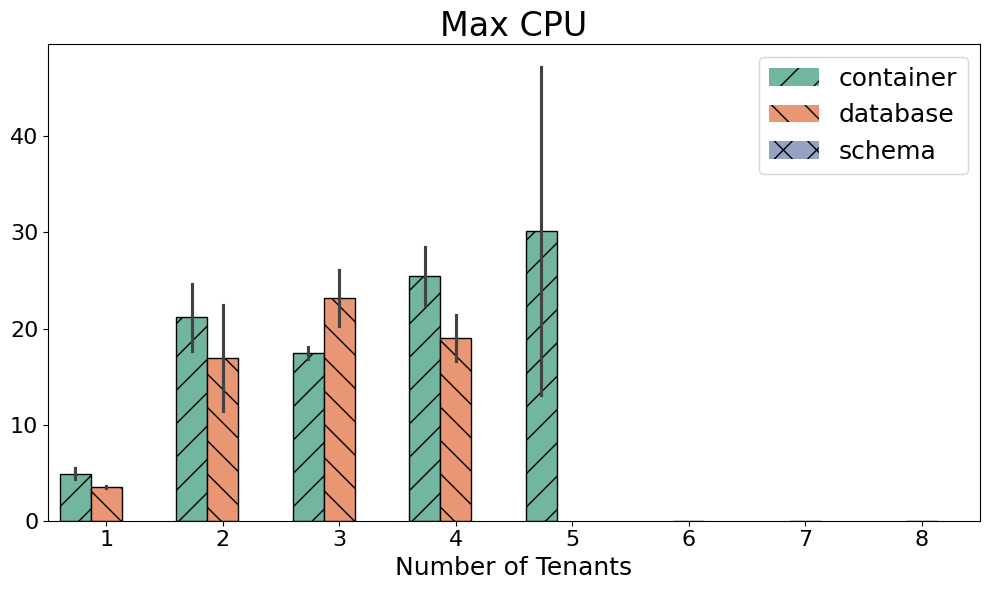

In [23]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

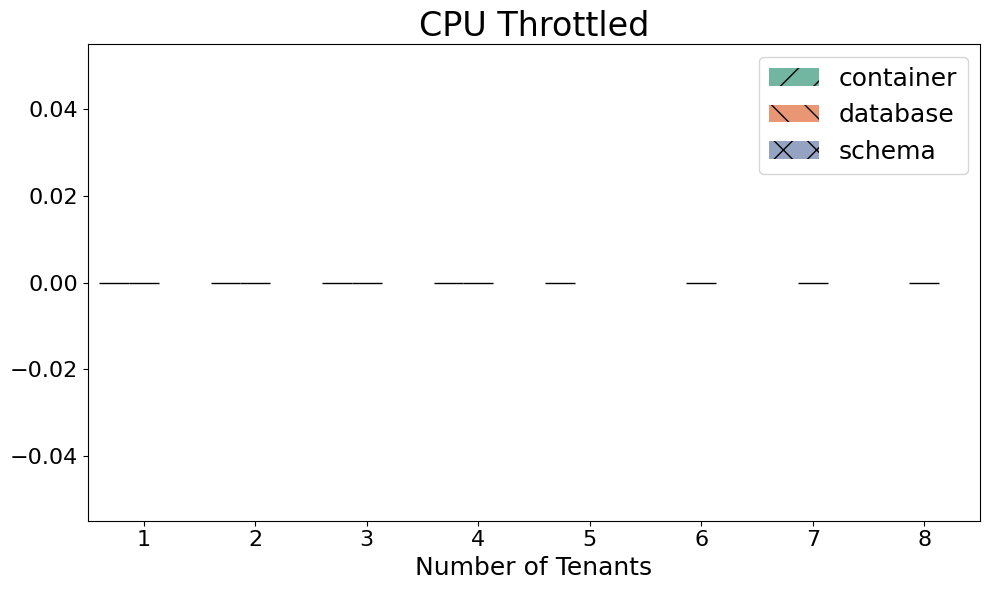

In [24]:
plot_bars(df_performance, y='CPU Throttled', title='CPU Throttled', estimator='sum')

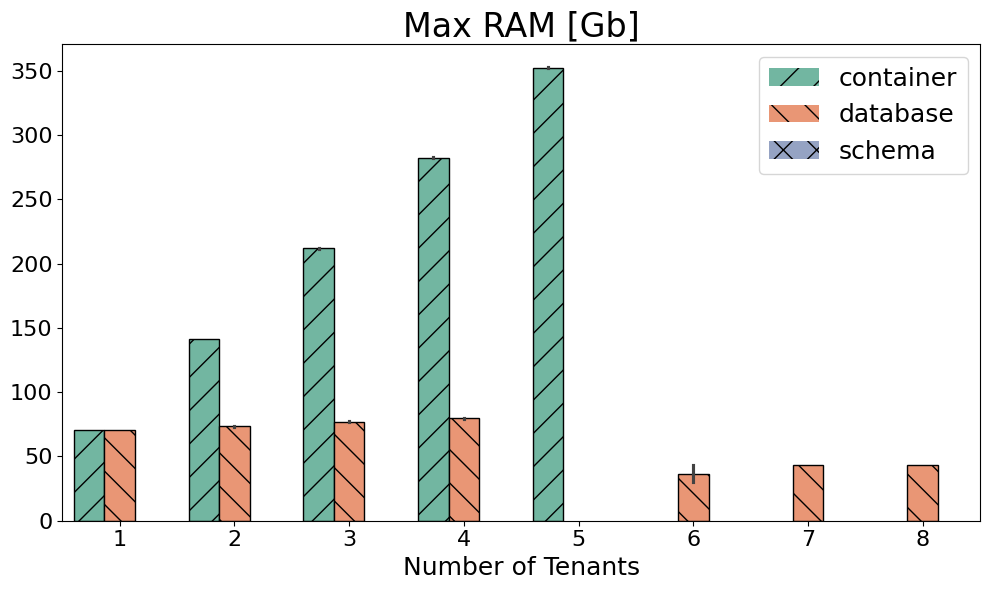

In [25]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

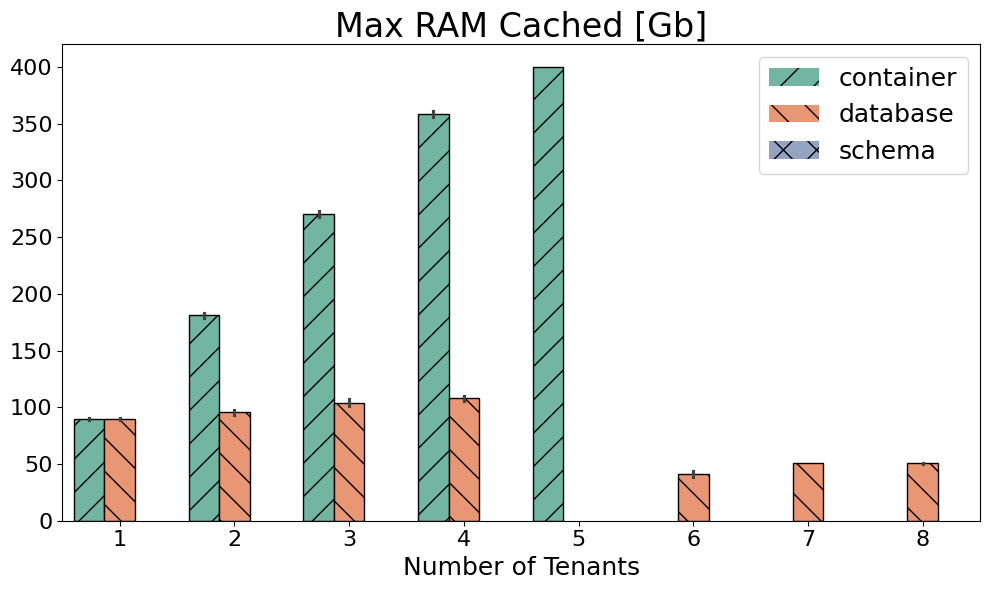

In [26]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

# Hardware Monitoring for Loading Phase

In [27]:
df_performance = collect.get_monitoring_all("loading")

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Locks,Access Exclusive,Access Share,Exclusive,...,Heap Reads,Heap Hits,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],type,num_tenants
0,1,942.31,35.00,43.69,0.94,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,377.34,container,1
1,2,942.31,35.00,43.69,0.94,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,377.34,container,1
0,1,746.85,35.02,43.73,0.34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,348.76,database,1
1,2,746.85,35.02,43.73,0.34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,348.76,database,1
0,1,1949.51,69.96,87.38,1.34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,975.27,container,2
1,2,1949.51,69.96,87.38,1.34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,975.27,container,2
0,1,1629.21,36.22,45.57,1.68,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,639.26,database,2
1,2,1629.21,36.22,45.57,1.68,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,639.26,database,2
0,1,2880.20,104.95,131.05,2.53,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1915.97,container,3
1,2,2880.20,104.95,131.05,2.53,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1915.97,container,3


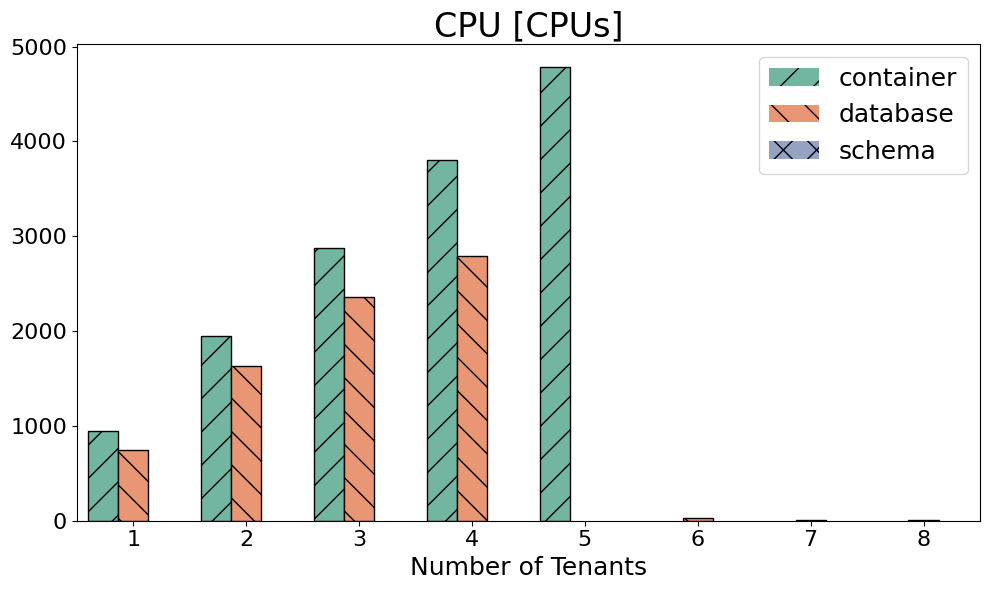

In [28]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

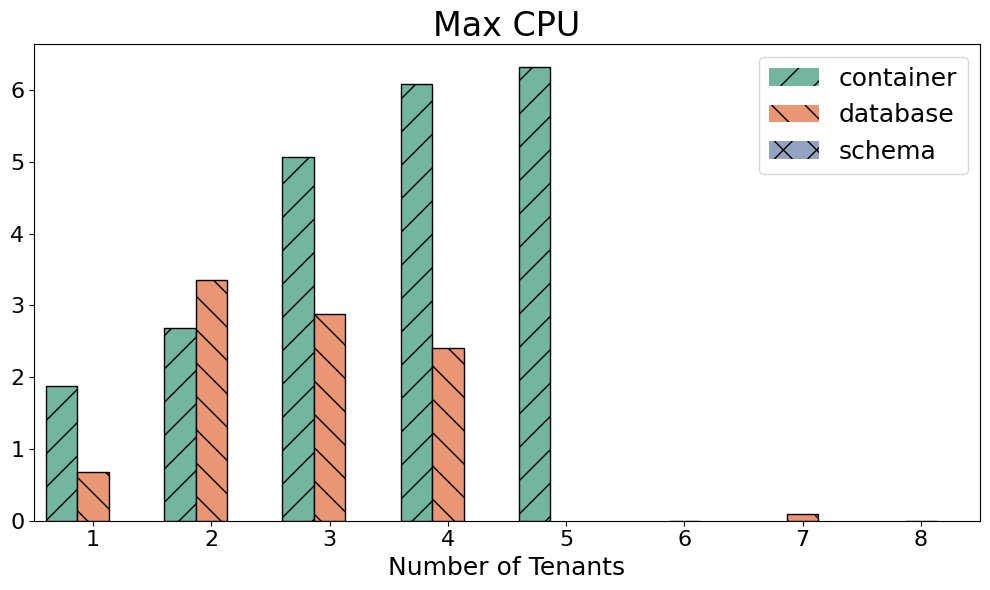

In [29]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

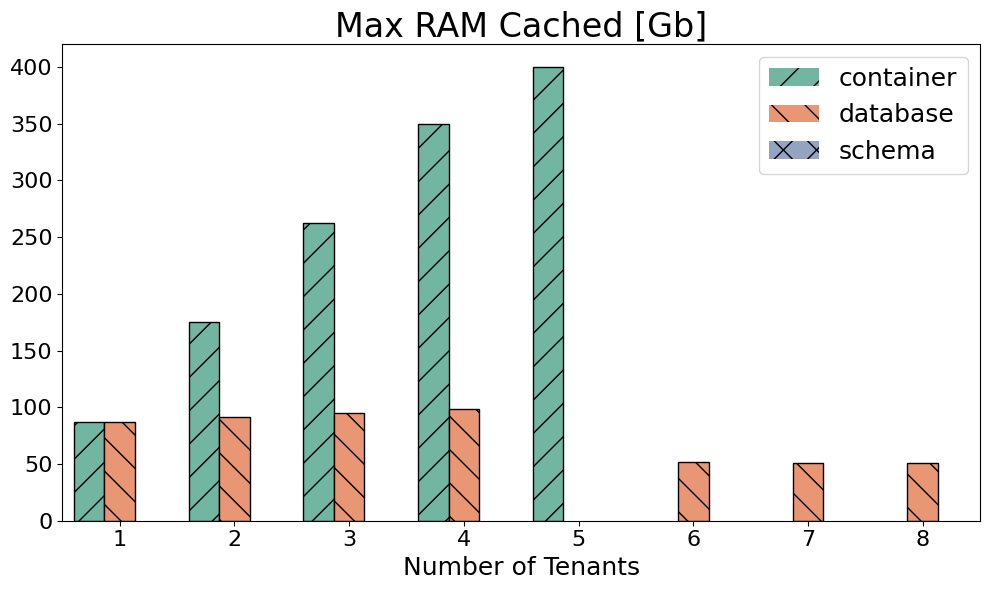

In [30]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

# Efficiency

In [31]:
client = '1'

df_performance_monitoring = collect.get_monitoring_all(type="stream")
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = collect.get_performance_all()
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
#merged_df['I_Lat'] = 1./merged_df['E_Lat']
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']
merged_df

1753416259 has missing performance
1753412871 has missing performance
1753409786 has missing performance


,type,num_tenants,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),client_y,CPU [CPUs],Max RAM [Gb],...,Heap Hits,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],E_Tpx,E_Lat,E_RAM
0,container,1,1,137.648326,0.0,6.667170e+05,26456247.0,1,700.59,35.24,...,0.0,0.0,0.0,0.0,0.0,NaN,801.47,117.884919,0.046270,3.906025
1,database,1,1,126.946655,0.0,7.316230e+05,34515793.0,1,656.12,35.23,...,0.0,0.0,0.0,0.0,0.0,NaN,764.58,116.088510,0.045642,3.603368
2,container,2,1,527.756637,0.0,3.717305e+05,7190948.0,1,2620.10,70.58,...,0.0,0.0,0.0,0.0,0.0,NaN,5567.45,120.855686,0.032043,7.477425
3,database,2,1,248.508330,0.0,8.442900e+05,38571084.0,1,1220.12,36.62,...,0.0,0.0,0.0,0.0,0.0,NaN,1057.74,122.205191,0.031157,6.786137
4,container,3,1,673.591634,0.0,4.113660e+05,5001958.0,1,3221.89,105.81,...,0.0,0.0,0.0,0.0,0.0,NaN,11649.02,125.440341,0.027468,6.366049
5,database,3,1,871.856616,0.0,3.361153e+05,5394831.0,1,3563.88,38.26,...,0.0,0.0,0.0,0.0,0.0,NaN,4397.91,146.782150,0.028893,22.787679
6,container,4,1,713.558294,0.0,5.144892e+05,8471862.0,1,3534.78,141.00,...,0.0,0.0,0.0,0.0,0.0,NaN,16417.19,121.120685,0.023449,5.060697
7,database,4,1,891.009938,0.0,4.494618e+05,11655561.0,1,4138.00,39.58,...,0.0,0.0,0.0,0.0,0.0,NaN,5103.21,129.194288,0.023188,22.511620
8,container,5,1,457.719971,0.0,1.669692e+06,78723888.0,1,2297.15,176.07,...,0.0,0.0,0.0,0.0,0.0,NaN,9778.23,119.553352,0.016147,2.599648


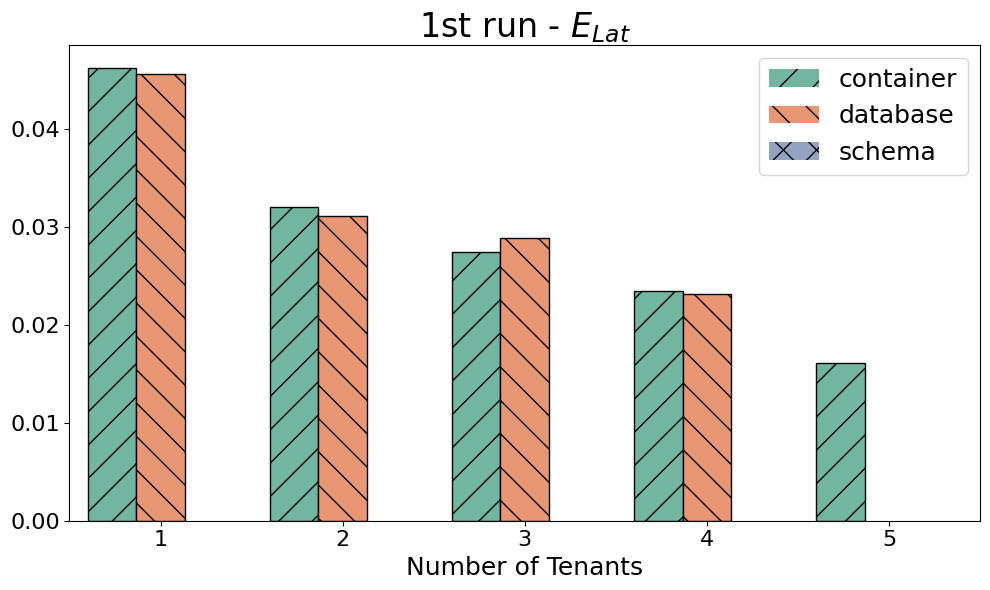

In [32]:
plot_bars(merged_df, y='E_Lat', title='1st run - $E_{Lat}$', estimator='max')

In [33]:
#plot_bars(merged_df, y='I_Lat', title='1st run - $I_{Lat}$', estimator='max')

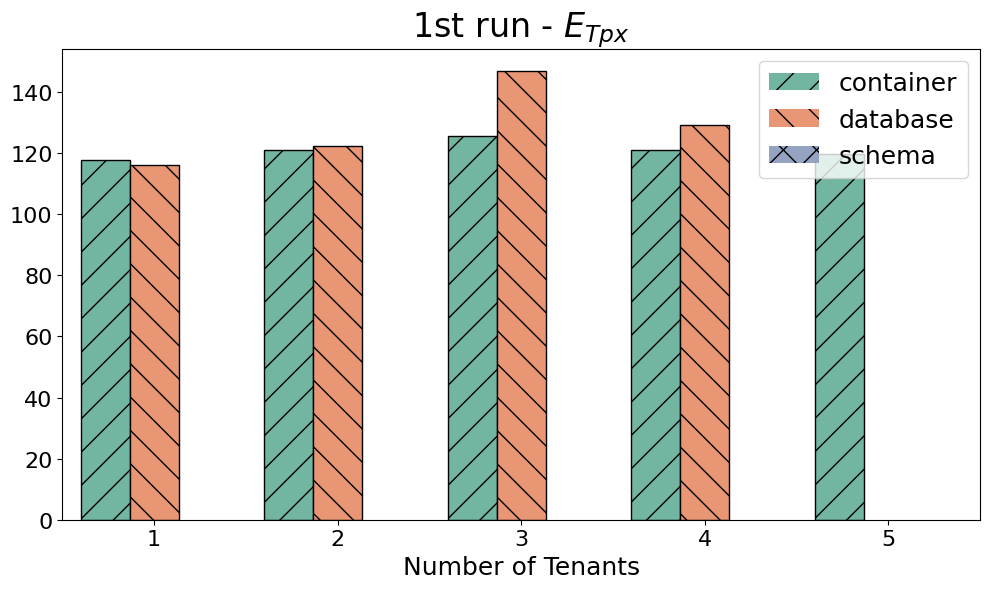

In [34]:
plot_bars(merged_df, y='E_Tpx', title='1st run - $E_{Tpx}$', estimator='max')

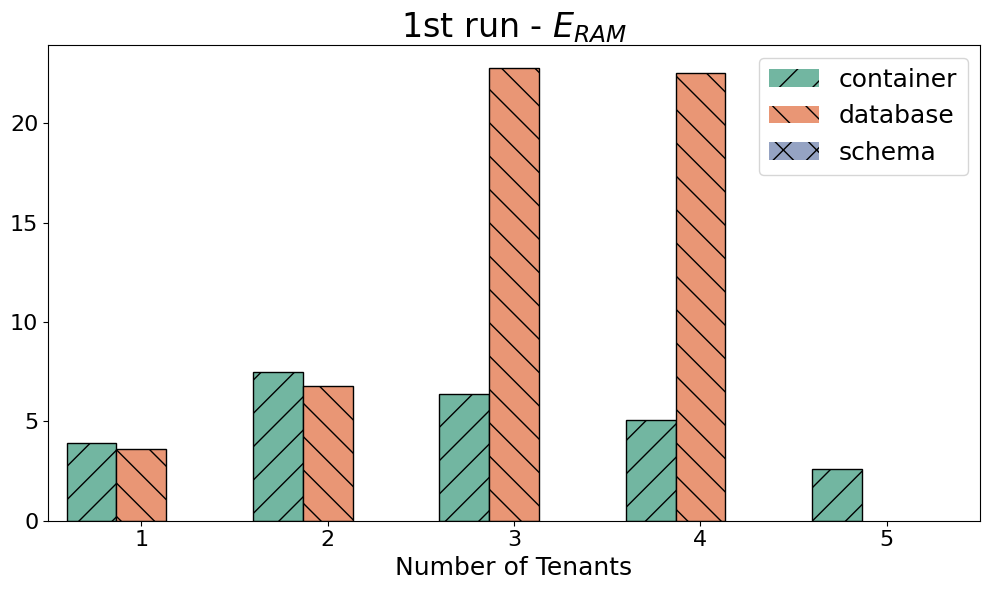

In [35]:
plot_bars(merged_df, y='E_RAM', title='1st run - $E_{RAM}$', estimator='min')

In [36]:
client = '2'

df_performance_monitoring = collect.get_monitoring_all(type="stream")
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = collect.get_performance_all()
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
#merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600.
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']

merged_df

1753416259 has missing performance
1753412871 has missing performance
1753409786 has missing performance


,type,num_tenants,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),client_y,CPU [CPUs],Max RAM [Gb],...,Heap Hits,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],E_Tpx,E_Lat,E_RAM
0,container,1,2,334.096649,0.0,286700.00,5554899.0,2,1683.87,35.39,...,0.0,0.0,0.0,0.0,0.0,NaN,1984.75,119.046001,0.045513,9.440425
1,database,1,2,273.379994,0.0,356458.00,7978867.0,2,1113.02,35.35,...,0.0,0.0,0.0,0.0,0.0,NaN,847.76,147.372011,0.050205,7.733522
2,container,2,2,644.303280,0.0,337876.50,4643754.0,2,2915.48,70.87,...,0.0,0.0,0.0,0.0,0.0,NaN,7196.91,132.596337,0.031861,9.091340
3,database,2,2,647.358296,0.0,306563.50,4304322.0,2,2991.14,36.92,...,0.0,0.0,0.0,0.0,0.0,NaN,4067.63,129.855165,0.033023,17.534082
4,container,3,2,703.879959,0.0,472250.00,6407031.0,2,3332.82,106.14,...,0.0,0.0,0.0,0.0,0.0,NaN,10977.06,126.717907,0.025206,6.631618
5,database,3,2,751.843310,0.0,349534.00,5255439.0,2,3545.28,38.68,...,0.0,0.0,0.0,0.0,0.0,NaN,6058.52,127.241286,0.028407,19.437521
6,container,4,2,779.558275,0.0,498377.00,6416643.0,2,3794.68,141.40,...,0.0,0.0,0.0,0.0,0.0,NaN,15154.19,123.260714,0.022995,5.513142
7,database,4,2,597.201634,0.0,709452.25,25947350.0,2,2906.31,40.00,...,0.0,0.0,0.0,0.0,0.0,NaN,3893.70,123.290695,0.022023,14.930041
8,container,5,2,925.206634,0.0,559346.20,7459586.0,2,4727.81,176.54,...,0.0,0.0,0.0,0.0,0.0,NaN,37954.50,117.416728,0.019446,5.240776


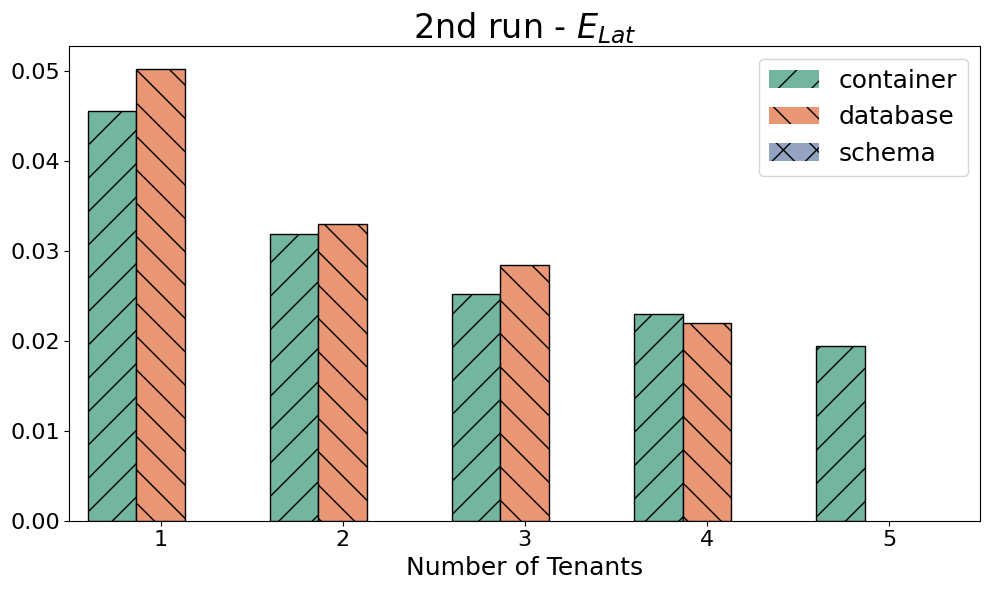

In [37]:
plot_bars(merged_df, y='E_Lat', title='2nd run - $E_{Lat}$', estimator='max')

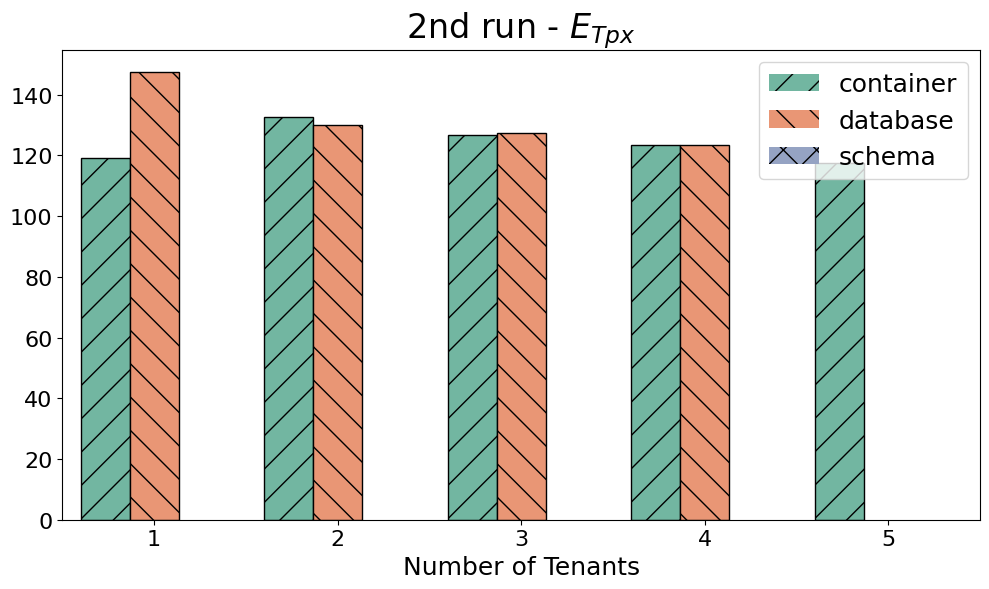

In [38]:
plot_bars(merged_df, y='E_Tpx', title='2nd run - $E_{Tpx}$', estimator='max')

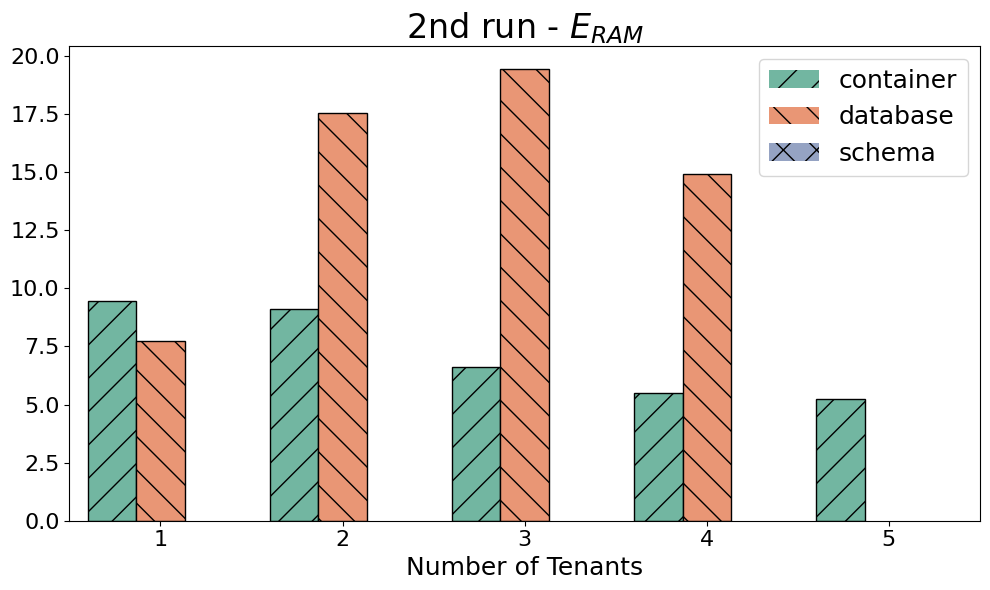

In [39]:
plot_bars(merged_df, y='E_RAM', title='2nd run - $E_{RAM}$', estimator='max')

In [40]:
import os
import zipfile

def zip_all_results():
    # Set the base directory containing the folders
    base_dir = path # "/path/to/your/folders"  # CHANGE THIS to your actual directory
    # List all folder names in the directory
    folder_names = codes
    # Create a zip for each folder
    for folder in folder_names:
        folder_path = os.path.join(base_dir, folder)
        zip_path = os.path.join(base_dir, f"{folder}.zip")
        print(f"Zipping {folder_path} to {zip_path}...")
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    abs_path = os.path.join(root, file)
                    rel_path = os.path.relpath(abs_path, folder_path)
                    zipf.write(abs_path, arcname=os.path.join(folder, rel_path))
    print("✅ Done zipping all folders.")


In [41]:
#zip_all_results()